# 투빅스 17기 정규세션 KNN 실습 자료 2

**투빅스 16기 박한나**

### Reference
[고려대학교 김성범 교수님: K-nearest neighbors 알고리즘 파이썬 실습](https://www.youtube.com/watch?v=lGo7otnuVcg)

위 강의의 코드를 정리한 자료입니다. 파이썬 및 모델 구현에 능숙하신 분들은 해당 파일을 쭉 따라서 실습을 진행해주시고, 구현이 어려우신 분들은 위 링크의 강의를 참고해주세요.

> **목표:** K-Nearest Neighbor 모델 구축

### 목차
1. 데이터 전처리
2. K-Nearest Neighbor 모델 구축
    + K-fold cross validation 활용
    + K 개수 선정: "인접한 학습 데이터를 몇 개까지 탐색할 것인가?"
    + Distance measure 선정: "데이터 간 거리는 어떻게 측정할 것인가?"
3. 예측 결과 평가 및 weighted KNN 구축

---

## 1. 모듈 불러오기 

In [ ]:
from IPython.display import display, HTML
import warnings
warnings.filterwarnings(action='ignore')

# 실습용 데이터 패키지
from sklearn.datasets import load_breast_cancer

# 데이터 전처리
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 기계학습 모델 및 평가
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, recall_score, precision_score
from tqdm import tqdm

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold
from scipy.stats import spearmanr

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
from matplotlib.colors import ListedColormap
matplotlib.rcParams['axes.unicode_minus'] = False

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')

## 2. 데이터 불러오기: Breast Cancer 

**데이터 구조**
+ 데이터: 위스콘신 대학교에서 제공한 유방암 진단결과
+ 관측치 개수: 569개
+ 변수 개수: 32개 (ID, 진단결과, 30개의 실측변수 값)

**설명 변수(원인: 예측값을 설명할 수 있는 변수)**
+ id: 환자 식별 번호
+ radius: 반경(중심에서 외벽까지 거리들의 평균값)
+ texture: 질감(Gray-Scale 값들의 표준편차)
+ perimeter: 둘레
+ area: 면적
+ smoothness: 매끄러움(반경길이의 국소적 변화)
+ compactness: 조그만 정도(둘레^2/면적-1)
+ concavity: 오목함(윤곽의 오목한 부분의 정도)
+ points: 오목한 점의 수
+ symmetry: 대칭
+ dimenstion: 프렉탈 차원(해안선 근사-1)
+ mean: 3~12번까지는 평균값을 의미
+ se: 13~22번까지는 표준오차를 의미
+ worst: 23~32는 각 세포별 구분들에서 제일 큰 3개의 값을 평균낸 값

**반응 변수(결과: 예측하고자 하는 값)**
+ diagnosis: 양성여부(Maligant=1 악성(유방암), Benign=0 양성(단순낭종))

In [ ]:
# 데이터 셋 로드 및 설명
breast_cancer = load_breast_cancer()
print(breast_cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [ ]:
breast_cancer.data.shape

(569, 30)

## 3. 탐색적 데이터 분석 및 데이터 전처리

X: 독립변수, 예측변수, 입력변수  
y: 종속변수, 반응변수, 출력변수

In [ ]:
# 데이터 프레임 형태로 변환
X = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
y = pd.DataFrame(breast_cancer.target, columns=['diagnosis'])

In [ ]:
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
y.tail()

,diagnosis
564,0
565,0
566,0
567,0
568,1


**결측치, 데이터 타입 확인**

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [ ]:
X.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [ ]:
y['diagnosis'].value_counts()

1    357
0    212
Name: diagnosis, dtype: int64

**Train/Test 데이터 분리**
+ Training 데이터 70% / Testing 데이터 30% 나누기

In [ ]:
# Train set / Test set 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=2021)

# 데이터 컬럼 단위 정규화 하기
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

print(f'Train set dimension is {X_train.shape}')
print(f'Test set dimension is {X_test.shape}')

Train set dimension is (398, 30)
Test set dimension is (171, 30)


## 4. 모델링
+ K 개수 결정
+ Distance measure 결정

### K에 따른 결과

+ K가 매우 작을 경우: 데이터의 지역적 특성을 지나치게 반영 (overfiting)
+ K가 매우 클 경우: 다른 범주의 개체를 너무 많이 포함하여 오분류할 위험 (underfitting)

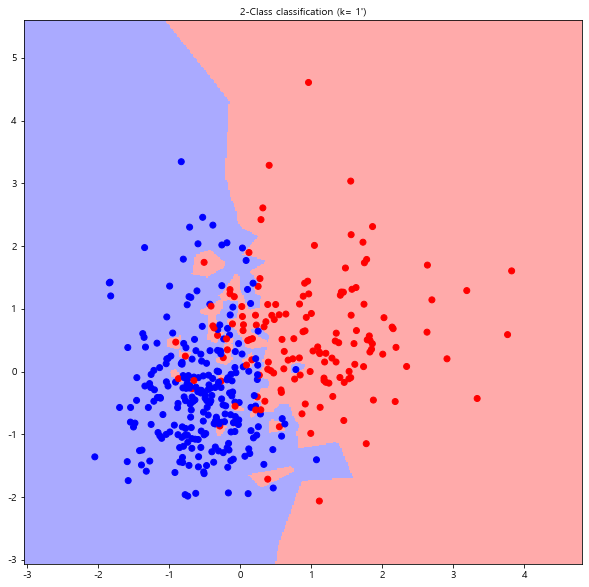

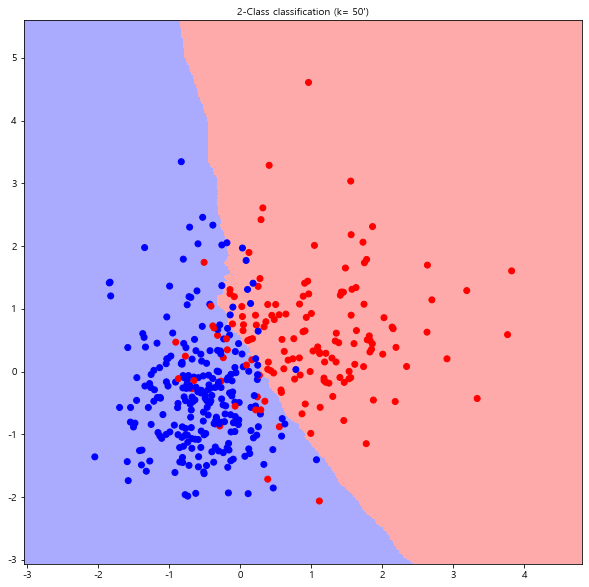

In [ ]:
 # we only take first two feature. We could avoid this ugly sclicing by using a two-dim dataset
X_vis = X_train[:,:2]

y_vis = y_train.values.ravel()

h = .02 # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for k in [1, 50]:
    # we create an instance of Neighbors Classifier and fit the data.
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_vis, y_vis)
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
    y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(10, 10))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    
    # Plot also the training points
    plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_vis, cmap = cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"2-Class classification (k= {k}')", fontsize=10)

### 4.1 Hyperparameter K 결정

In [ ]:
# 탐색해볼 K 리스트:1~100 사이의 홀수 값들
k_list = [i for i in range(1, 100) if i%2 !=0] 
cv_scores = []

for k in tqdm(k_list):
    classifier = KNeighborsClassifier(n_neighbors = k, p=2)
    # p=1: manhattan_distance, p=2: euclidean_distance, # p=l_p: minkoski_distance
    
    # 10-cross validation으로 탐색
    # scores: k값마다 10개의 값 누적 
    scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring = 'accuracy')
    
    # scores의 평균을 k값 마다의 성능 평가 결과로 사용
    cv_scores.append(scores.mean())

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.92it/s]


In [ ]:
# scoring이 accuracy이므로 값이 높을수록 좋음
# cv_scores를 가장 높게 만든 k값을 best_k값으로 선정
best_k = [k_list[i] for i in range(len(cv_scores)) if cv_scores[i] == np.max(cv_scores)]
print('Best k value :', best_k)

Best k value : [5]


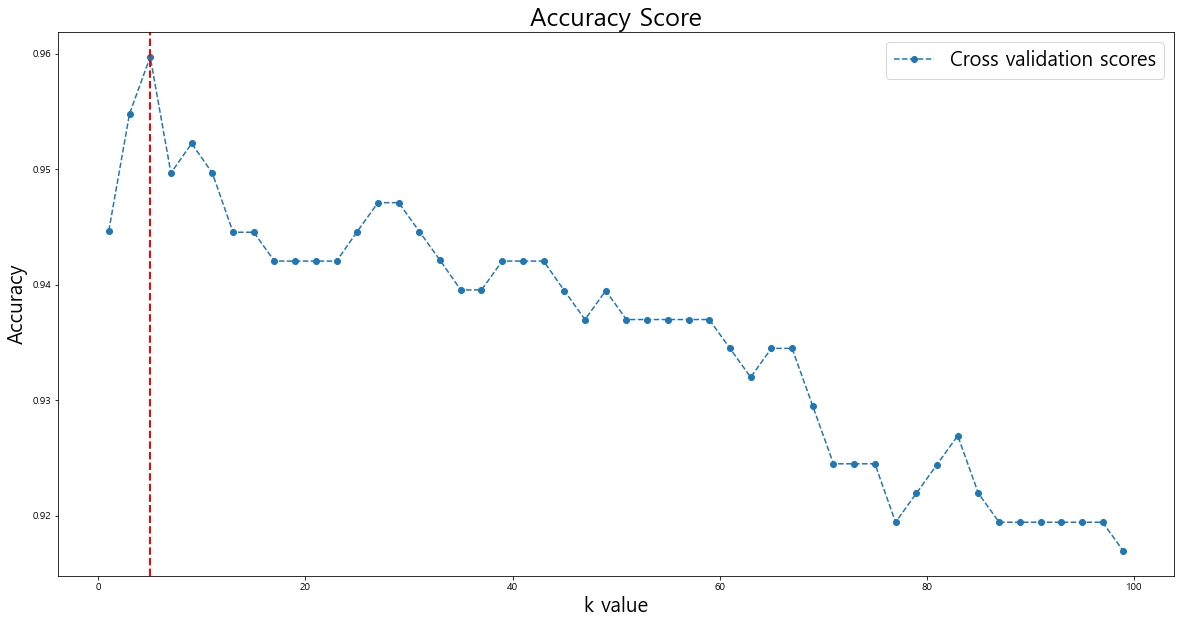

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(k_list, cv_scores, marker='o', linestyle='dashed')
plt.legend(['Cross validation scores'], fontsize=20)
plt.xlabel('k value', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.title('Accuracy Score', fontsize=25)
plt.axvline(best_k[0], color='r', linestyle='--', linewidth=2)
plt.show()

+ k에 1과 100사이의 홀수 값을 주어 결과를 비교해본다. 
+ accuracy를 기준으로 10-cross validation을 진행해 본다.
+ k가 5일 때 cross validation에서의 accuracy의 평균이 가장 높게 나타난다.

### 4.2 Distance type 결정
### 4.2.1 Euclidean Distance

> ### Distance measures: Euclidean distance
+ 가장 흔히 사용되는 거리측도
+ 대응되는 x, y 값 간 차이 제곱합의 제곱근으로써, 두 관측치 사이의 직선 거리를 의미

$$ d_{(X,Y)}=\sqrt{\sum_{i=1}^n(x_i-y_i)^2}$$

In [ ]:
k_list = [i for i in range(1, 100) if i%2 !=0] 

euc = []
for k in tqdm(k_list):
    classifier = KNeighborsClassifier(n_neighbors = k, p=2)
    scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring='accuracy')
    euc.append(scores.mean())

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.21it/s]


### 4.2.2 Manhattan Distance

> ### Distance measures: Manhattan distance
+ x에서 y로 이동 시 각 좌표축 방향으로만 이동할 경우에 계산되는 거리

$$ d_{Manhattan(X,Y)}=\sum_{i=1}^n|x_i-y_i|$$

In [ ]:
k_list = [i for i in range(1, 100) if i%2 !=0] 

man = []
for k in tqdm(k_list):
    classifier = KNeighborsClassifier(n_neighbors = k, p=1)
    scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring='accuracy')
    man.append(scores.mean())

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.37it/s]


> Mahalanobis Distance와  Correlation Distance는 KNeighborsClassifier에서의 p옵션에서 제공해주지 않는다. 따라서 아래와 같이 수정하여 구현한다.

### 4.2.3 Mahalanobis Distance

> ### Distance measures: Mahalanobis distance
+ 변수 내 분산, 변수 간 공분산을 모두 반영하여 x,y 간 거리를 계산하는 방식
+ 데이터의 covariance matrix가 identity matrix인 경우는 Euclidean distance와 동일함

$$d_{Mahalanobis(X,Y)}=\sqrt{(X-Y)^T\Sigma^{-1}(X-Y)},$$  
$$\Sigma^{-1}:\ inverse \ of \ covariance  \ matrix$$

In [ ]:
y_train = y_train.values.ravel()
kf = KFold(n_splits=10)
kf.get_n_splits(X_train)

k_list = [i for i in range(1, 100) if i%2 !=0] 

mah = []
for k in tqdm(k_list):
    
# K-fold cross validation
    mah_acc = []
    for train_index, valid_index in kf.split(X_train):
        X_train_f = X_train[train_index]
        y_train_f = y_train[train_index]
        
        X_valid_f = X_train[valid_index]
        y_valid_f = y_train[valid_index]
        
        total = len(y_valid_f)
        correct = 0
        
        nn = NearestNeighbors(algorithm='brute', metric='mahalanobis',
                             metric_params={'V':np.cov(X_train_f, rowvar=False)}, n_neighbors=k)
        nn_model = nn.fit(X_train_f, y_train_f)
        
        for v in range(len(X_valid_f)):
            distance, indices = nn_model.kneighbors(X_valid_f[v].reshape(1,-1))
            
            class_list = {'0':0, '1':0}
            for i in range(len(indices[0])):
                if y_train_f[indices[0][i]] == 0:
                    class_list['0'] += 1
                else:
                    class_list['1'] += 1
                    
            max_key = np.int(max(class_list, key=class_list.get))
            if max_key == y_valid_f[v]:
                correct += 1
                    
        mah_acc.append(correct/total)
    
    mah.append(np.mean(mah_acc))   

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:35<00:00,  1.91s/it]


### 4.2.4 Correlation Distance: Pearson Correlation

> ### Distance measures: Correlation distance
+ 데이터 간 Pearson correation을 거리측도로 사용하는 방식으로, 데이터 패턴의 유사도를 반영할 수 있음

$$d_{Corr(X,Y)}=1-r$$  
$$where \ r=\sigma_{XY}$$

In [ ]:
kf = KFold(n_splits=10)
kf.get_n_splits(X_train)

k_list = [i for i in range(1, 100) if i%2 !=0]

pear = []
for k in tqdm(k_list):
    
# K-fold cross validation
    pear_acc = []
    for train_index, valid_index in kf.split(X_train):
        X_train_f = X_train[train_index]
        y_train_f = y_train[train_index]
        
        X_valid_f = X_train[valid_index]
        y_valid_f = y_train[valid_index]
        
        total = len(y_valid_f)
        correct = 0
        
        nn = NearestNeighbors(metric='correlation', n_neighbors=k)
        nn_model = nn.fit(X_train_f, y_train_f)
        
        for v in range(len(X_valid_f)):
            distance, indices = nn_model.kneighbors(X_valid_f[v].reshape(1,-1))
            
            class_list = {'0':0, '1':0}
            for i in range(len(indices[0])):
                if y_train_f[indices[0][i]] == 0:
                    class_list['0'] += 1
                else:
                    class_list['1'] += 1
                    
            max_key = np.int(max(class_list, key=class_list.get))
            if max_key == y_valid_f[v]:
                correct += 1
                
        pear_acc.append(correct/total)
            
    pear.append(np.mean(pear_acc))         

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


### 4.2.6 Correlation Distance: Spearman Rank Correlation

> ### Distance measures: Spearman rank correlation distance
+ $\rho$를 Spearman correlation이라 하며, 이는 데이터의 rank를 이용하여 correlation distance를 계산하는 방식
+ $\rho$의 범위는 -1부터 1로, Pearson correlation과 동일

$$d_{Spearman(X,Y)}=1-\rho$$  
$$where \ \rho = 1-{6\sum_{i=1}^n(rank(x_i)-rank(y_i))^2 \over n(n^2-1)}$$

돌리는데 굉장히 오래 걸림!

In [ ]:
def spearmancorr(x,y):
    rho, pval = spearmanr(x, y, axis=0)
    return 1-rho

kf = KFold(n_splits=10)
kf.get_n_splits(X_train)

k_list = [i for i in range(1,100) if i%2 !=0]

spear = []
for k in tqdm(k_list):
    
# K-fold cross validation
    spear_acc = []
    for train_index, valid_index in kf.split(X_train):
        X_train_f = X_train[train_index]
        y_train_f = y_train[train_index]
        
        X_valid_f = X_train[valid_index]
        y_valid_f = y_train[valid_index]
        
        total = len(y_valid_f)
        correct = 0
        
        nn = NearestNeighbors(metric = spearmancorr, n_neighbors=k, algorithm='ball_tree')
        nn_model = nn.fit(X_train_f, y_train_f)
        
        for v in range(len(X_valid_f)):
            distance, indices = nn_model.kneighbors(X_valid_f[v].reshape(1, -1))
            
            class_list = {'0':0, '1':0}
            for i in range(len(indices[0])):
                if y_train_f[indices[0][i]] == 0:
                    class_list['0'] += 1
                else:
                    class_list['1'] += 1
                    
            max_key = np.int(max(class_list, key=class_list.get))
            if max_key == y_valid_f[v]:
                correct += 1
                
        spear_acc.append(correct/total)
    spear.append(np.mean(spear_acc))                   

100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [1:48:20<00:00, 130.02s/it]


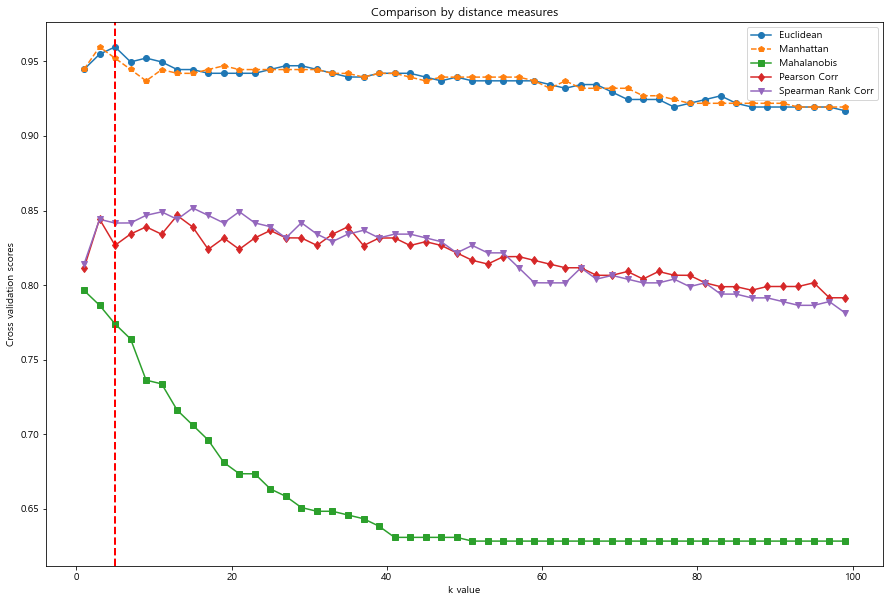

In [ ]:
plt.figure(figsize=(15,10))
# plt.plot(k_list, acc_spear, marker='o', linestyle='dashed')
plt.plot(k_list, euc, marker='o')
plt.plot(k_list, man, linestyle='dashed', marker='p')
plt.plot(k_list, mah, marker='s')
plt.plot(k_list, pear, marker='d')
plt.plot(k_list, spear, marker='v')
plt.axvline(5, color='r', linestyle='--', linewidth=2)
plt.xlabel('k value')
plt.ylabel('Cross validation scores')
plt.title('Comparison by distance measures')
plt.legend(['Euclidean', 'Manhattan', 'Mahalanobis', 'Pearson Corr', 'Spearman Rank Corr'])
plt.show()

### 4.3 최종 모델 선정 및 성능 확인

**최종모델:** 유클리디언 거리 & k=5

In [ ]:
classifier = KNeighborsClassifier(n_neighbors = 5, p=2)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

acc = accuracy_score(y_true = y_test, y_pred = y_pred) # 정확도
recall = recall_score(y_true = y_test, y_pred = y_pred) # 민감도
precision = precision_score(y_true = y_test, y_pred = y_pred) # 정밀도

print(f"정확도:{acc:0.2f}", f"민감도:{recall:0.2f}", f"정밀도:{precision:0.2f}", sep=' | ')

정확도:0.98 | 민감도:0.99 | 정밀도:0.97


### 4.4 Weighted KNN 적용 및 성능확인

KNeighborsClassifier의 weights='distance' 옵션을 추가하면 된다. 
+ weights = 'uniform': 거리에 따른 가중치를 적용하지 않는것

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.77it/s]


Best k value:  [5]


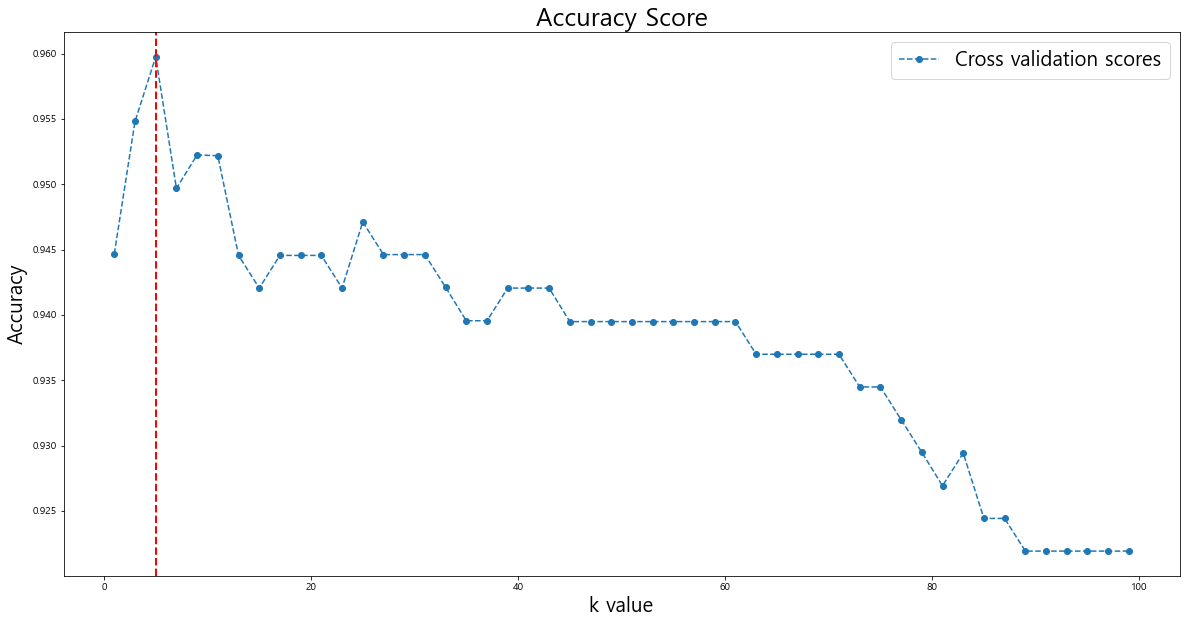

In [ ]:
k_list = [i for i in range(1, 100) if i%2 !=0]

euc = []
for k in tqdm(k_list):
    classifier = KNeighborsClassifier(n_neighbors = k, p=2, weights = 'distance') # weights{'uniform', 'distance'} or callable
                                                                                  # default = 'unifore'
    scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring='accuracy')
    euc.append(scores.mean())
    
best_k = [k_list[i] for i in range(len(euc)) if cv_scores[i] == np.max(euc)]
print("Best k value: ", best_k)

plt.figure(figsize=(20,10))
plt.plot(k_list, euc, marker='o', linestyle='dashed')
plt.legend(['Cross validation scores'], fontsize=20)
plt.xlabel('k value', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.title('Accuracy Score', fontsize=25)
plt.axvline(best_k[0], color='r', linestyle='--', linewidth=2)
plt.show()

In [ ]:
classifier = KNeighborsClassifier(n_neighbors = 5, p=2, weights='distance')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

acc = accuracy_score(y_true = y_test, y_pred = y_pred) # 정확도
recall = recall_score(y_true = y_test, y_pred = y_pred) # 민감도
precision = precision_score(y_true = y_test, y_pred = y_pred) # 정밀도

print(f"정확도:{acc:0.2f}", f"민감도:{recall:0.2f}", f"정밀도:{precision:0.2f}", sep=' | ')

정확도:0.98 | 민감도:0.99 | 정밀도:0.97


## 5. Regression 예시

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.31it/s]


Best k value:  [3]


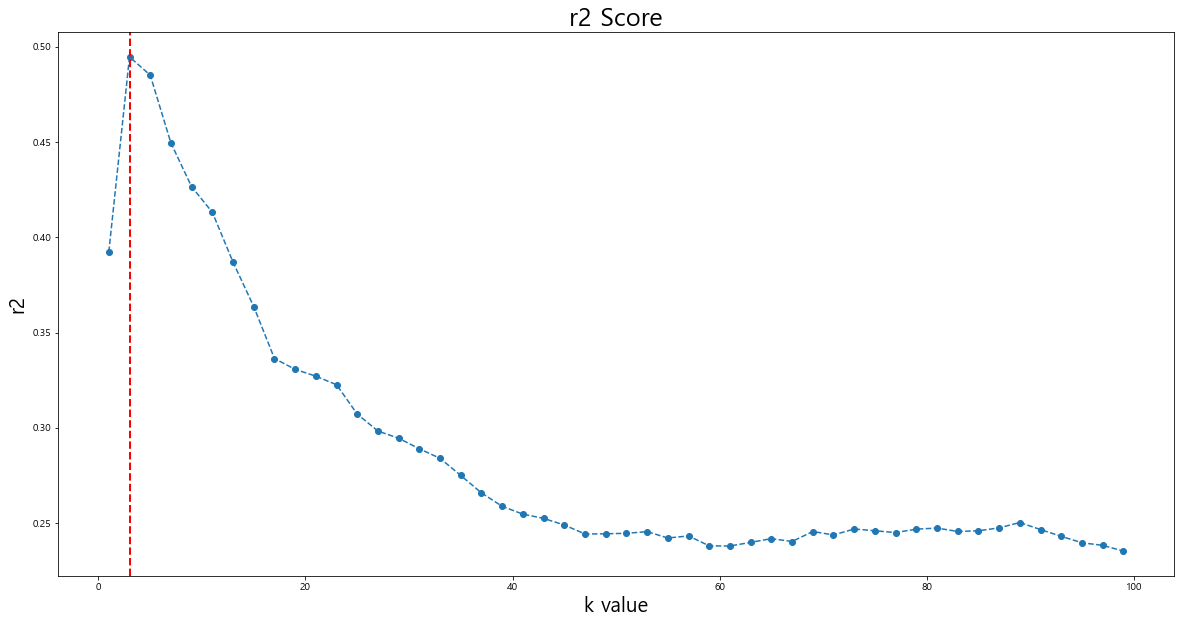

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import load_boston
boston = load_boston()

# 데이터 프레임 형태로 변환
X = pd.DataFrame(boston.data, columns = boston.feature_names)
y = pd.DataFrame(boston.target, columns = ['MEDV'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)

k_list = [i for i in range(1, 100) if i%2 !=0]
cv_scores = []
for k in tqdm(k_list):
    regressor = KNeighborsRegressor(n_neighbors = k, p=2) # p=1: manhattan_distance, p=2: euclidean_distance
                                                          # p=l_p: minkowski_distance
    scores = cross_val_score(regressor, X_train, y_train, cv=10, scoring = 'r2')
    cv_scores.append(scores.mean())
    
best_k = [k_list[i] for i in range(len(cv_scores)) if cv_scores[i] == np.max(cv_scores)]
print("Best k value: ", best_k)

plt.figure(figsize=(20, 10))
plt.plot(k_list, cv_scores, marker='o', linestyle='dashed')
plt.xlabel('k value', fontsize=20)
plt.ylabel('r2', fontsize=20)
plt.title('r2 Score', fontsize=25)
plt.axvline(best_k[0], color='r', linestyle='--', linewidth=2)
plt.show()